In [1]:
!nvidia-smi

Thu Aug  1 18:06:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install monai==1.2.0 gdown

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
import time

### Data list
Upload the spleen samples and copy them into `mydata` folder </br>
Link: https://drive.google.com/file/d/1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R/view?usp=sharing </br>
(source: http://medicaldecathlon.com/) </br>
Or using gdown:

In [4]:
!gdown --fuzzy https://drive.google.com/file/d/1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R
From (redirected): https://drive.google.com/uc?id=1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R&confirm=t&uuid=fdc1f080-1f93-4688-8758-5d3826bc32b3
To: /content/spleen_samples.zip
100% 58.7M/58.7M [00:00<00:00, 64.0MB/s]


In [5]:
!unzip spleen_samples.zip
!mv data/ mydata
!ls

Archive:  spleen_samples.zip
   creating: data/
   creating: data/spleen_img/
 extracting: data/spleen_img/spleen_10.nii.gz  
 extracting: data/spleen_img/spleen_3.nii.gz  
 extracting: data/spleen_img/spleen_56.nii.gz  
 extracting: data/spleen_img/spleen_8.nii.gz  
 extracting: data/spleen_img/spleen_9.nii.gz  
   creating: data/spleen_seg/
 extracting: data/spleen_seg/spleen_10.nii.gz  
 extracting: data/spleen_seg/spleen_3.nii.gz  
 extracting: data/spleen_seg/spleen_56.nii.gz  
 extracting: data/spleen_seg/spleen_8.nii.gz  
 extracting: data/spleen_seg/spleen_9.nii.gz  
mydata	sample_data  spleen_samples.zip


In [6]:
keys = ['img', 'seg']
data_dir = './mydata/'
fns = os.listdir(data_dir+'spleen_img/')
fpaths = [{key: data_dir+'spleen_'+key+'/'+fn for key in keys} for fn in fns]

In [7]:
fpaths

[{'img': './mydata/spleen_img/spleen_56.nii.gz',
  'seg': './mydata/spleen_seg/spleen_56.nii.gz'},
 {'img': './mydata/spleen_img/spleen_9.nii.gz',
  'seg': './mydata/spleen_seg/spleen_9.nii.gz'},
 {'img': './mydata/spleen_img/spleen_10.nii.gz',
  'seg': './mydata/spleen_seg/spleen_10.nii.gz'},
 {'img': './mydata/spleen_img/spleen_8.nii.gz',
  'seg': './mydata/spleen_seg/spleen_8.nii.gz'},
 {'img': './mydata/spleen_img/spleen_3.nii.gz',
  'seg': './mydata/spleen_seg/spleen_3.nii.gz'}]

### Preview

In [8]:
sample = monai.transforms.LoadImaged(keys)(fpaths[0])
sample['img'].shape

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


torch.Size([512, 512, 33])

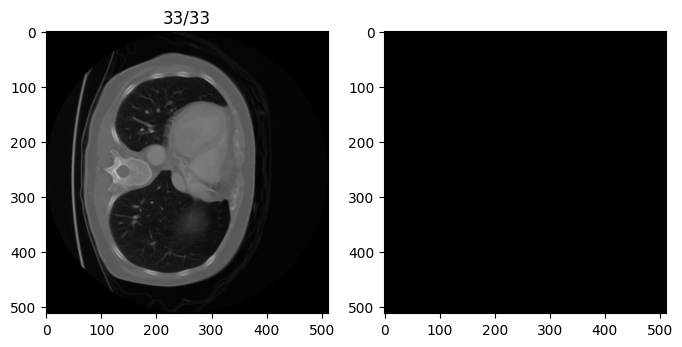

In [9]:
from IPython.display import clear_output

vmax = sample['img'].max()
vmin = sample['img'].min()
for i in range(sample['img'].shape[-1]):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(sample['img'][..., i], cmap='gray', vmax=vmax, vmin=vmin)
    plt.title(str(i+1)+'/'+str(sample['img'].shape[-1]))
    plt.subplot(122)
    plt.imshow(sample['seg'][..., i], cmap='gray')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Transforms
Fix the transforms below. Ref: https://docs.monai.io/en/stable/transforms.html

In [12]:
spatial_size = [128, 128, 16]
prob = 0.5
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.EnsureTyped(keys),
                                  monai.transforms.NormalizeIntensityd(keys),
                                  monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']),
                                  monai.transforms.RandScaleIntensityd(keys, 0.2, prob=prob),
                                  monai.transforms.RandFlipd(keys, prob=0.5),
                                  monai.transforms.ToDeviced(keys, device='cuda:0')])

In [13]:
data = trans(fpaths[0])
data['img'].shape, data['seg'].shape

(torch.Size([1, 128, 128, 16]), torch.Size([1, 128, 128, 16]))

### Dataset and DataLoader
Fix the dataset below. Ref: https://docs.monai.io/en/stable/data.html#cachedataset

In [19]:
ds = monai.data.CacheDataset(fpaths, transform=trans)

Loading dataset: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


In [20]:
for data in ds: print(data['img'].shape, data['seg'].shape)

torch.Size([1, 128, 128, 16]) torch.Size([1, 128, 128, 16])
torch.Size([1, 128, 128, 16]) torch.Size([1, 128, 128, 16])
torch.Size([1, 128, 128, 16]) torch.Size([1, 128, 128, 16])
torch.Size([1, 128, 128, 16]) torch.Size([1, 128, 128, 16])
torch.Size([1, 128, 128, 16]) torch.Size([1, 128, 128, 16])


In [21]:
batch_size = 2
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size)
for data in dl: print(data['img'].shape, data['seg'].shape)

torch.Size([2, 1, 128, 128, 16]) torch.Size([2, 1, 128, 128, 16])
torch.Size([2, 1, 128, 128, 16]) torch.Size([2, 1, 128, 128, 16])
torch.Size([1, 1, 128, 128, 16]) torch.Size([1, 1, 128, 128, 16])


### Network, loss and optimizer
Fix the network setting. Ref: https://docs.monai.io/en/stable/networks.html#unet

In [24]:
device = torch.device("cuda:0")

net = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[8, 16, 32],
    strides=[2, 2]

).to(device)

net(data['img']).shape

torch.Size([1, 1, 128, 128, 16])

In [25]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)

### Training

In [26]:
max_epochs = 200
epoch_loss_values = []

# Set to training mode
net.train()
t1 = time.time()
for epoch in range(max_epochs):
    print('Epoch: '+str(epoch+1)+'/'+str(max_epochs))
    epoch_loss = 0
    for step, batch_data in enumerate(dl):
        inputs, labels = (
            batch_data["img"],
            batch_data["seg"]
        )
        # Reset optimizer
        optimizer.zero_grad()
        # Forward
        outputs = net(inputs)
        # Loss
        loss = loss_function(outputs, labels)
        # Backward
        loss.backward()
        # Update weights
        optimizer.step()
        epoch_loss += loss.item()
        print('  Step '+str(step+1)+'/'+str(len(dl))+f', train_loss: {loss.item():.4f}')
    epoch_loss /= (step+1)
    epoch_loss_values.append(epoch_loss)
t2 = time.time()

Epoch: 1/200
  Step 1/3, train_loss: 0.9863
  Step 2/3, train_loss: 0.9851
  Step 3/3, train_loss: 0.9862
Epoch: 2/200
  Step 1/3, train_loss: 0.9729
  Step 2/3, train_loss: 0.9781
  Step 3/3, train_loss: 0.9739
Epoch: 3/200
  Step 1/3, train_loss: 0.9633
  Step 2/3, train_loss: 0.9650
  Step 3/3, train_loss: 0.9681
Epoch: 4/200
  Step 1/3, train_loss: 0.9553
  Step 2/3, train_loss: 0.9556
  Step 3/3, train_loss: 0.9575
Epoch: 5/200
  Step 1/3, train_loss: 0.9493
  Step 2/3, train_loss: 0.9418
  Step 3/3, train_loss: 0.9452
Epoch: 6/200
  Step 1/3, train_loss: 0.9500
  Step 2/3, train_loss: 0.9440
  Step 3/3, train_loss: 0.9274
Epoch: 7/200
  Step 1/3, train_loss: 0.9331
  Step 2/3, train_loss: 0.9349
  Step 3/3, train_loss: 0.9245
Epoch: 8/200
  Step 1/3, train_loss: 0.9228
  Step 2/3, train_loss: 0.9244
  Step 3/3, train_loss: 0.9161
Epoch: 9/200
  Step 1/3, train_loss: 0.9183
  Step 2/3, train_loss: 0.9177
  Step 3/3, train_loss: 0.9321
Epoch: 10/200
  Step 1/3, train_loss: 0.9040
 

Timespan: 12.5961 seconds


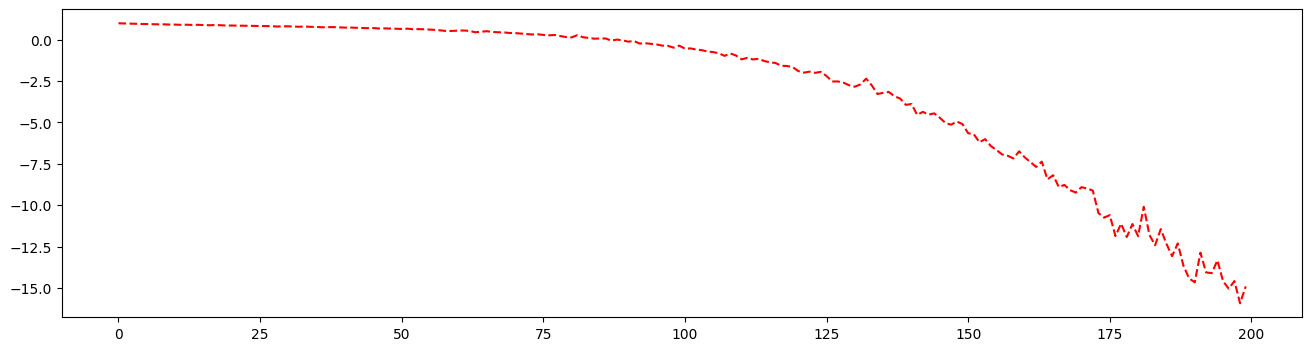

In [27]:
plt.figure(figsize=(16, 4))
plt.plot(epoch_loss_values, ls='--', c='r')
print('Timespan:', round(t2-t1, 4), 'seconds')

### The result should be as below:
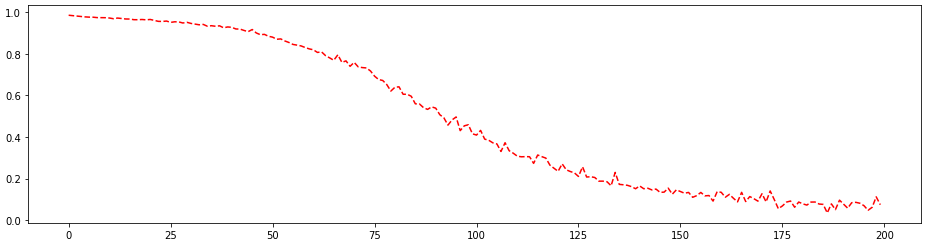

### How to accelerate the training procedure?